### Student Name: Aidan Keeshan
### Student ID: 18200117

# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [92]:
import pandas as pd
import numpy as np

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [19]:
def df_summary(df):
    print ("Describe")
    display(df.describe())
    print ("Info")
    df.info()
    print ("Head")
    display(df.head(5))
    
lab5_df = pd.read_csv("winequality_red.csv")
df_summary(lab5_df)

Describe


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Head


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


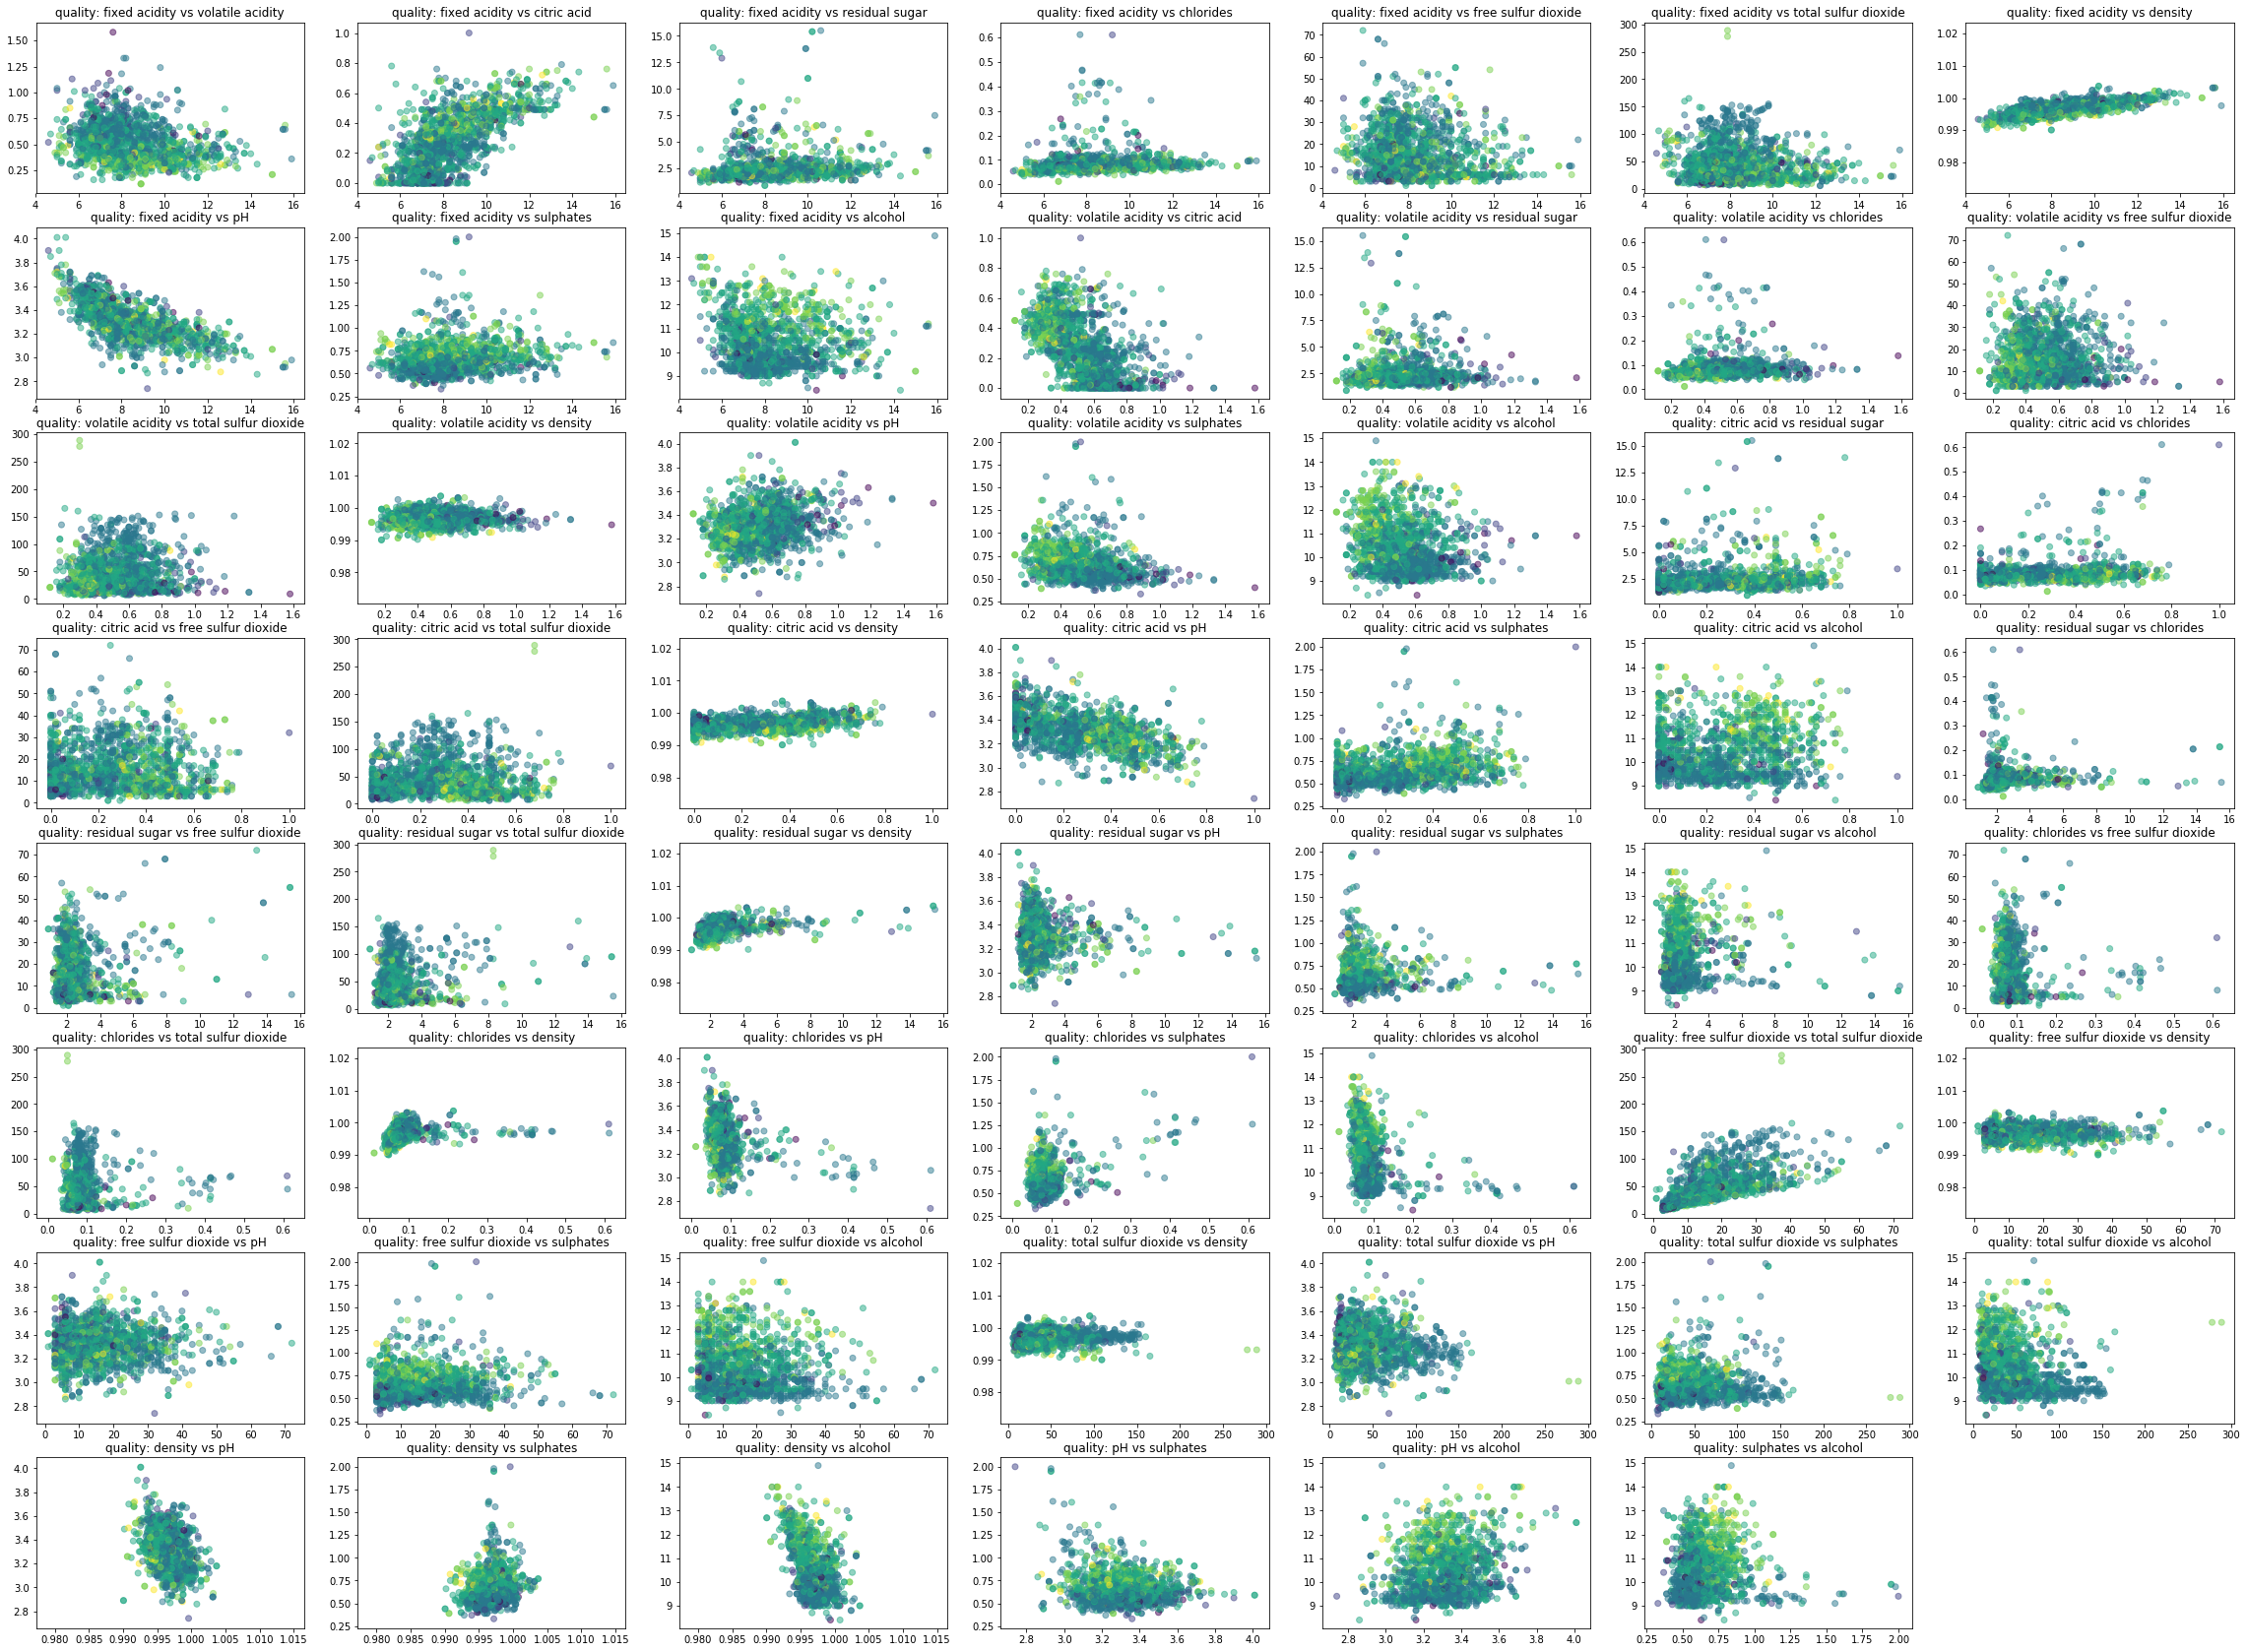

In [60]:
import matplotlib.pyplot as plt
from scipy.special import comb
num_cols = lab5_df.columns.values 
num_cols = np.delete(num_cols, np.where(num_cols == 'quality'), axis=0)
ln_num = (len(num_cols))
ncr = comb(ln_num,2)

width = 7
hieght = int(np.ceil(ncr/width))
f = plt.figure(figsize=(40,30))
k = 1

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        if i<j:
            ax = f.add_subplot(hieght,width,k)
            ax.scatter(lab5_df[num_cols[i]],lab5_df[num_cols[j]], alpha=0.5, c=lab5_df['quality'], cmap='viridis')
            ax.set_title("{}: {} vs {}".format('quality',num_cols[i],num_cols[j]))
            k += 1
f.show()

## target attribute
target_attribute_name = 'quality'
target = lab5_df[target_attribute_name]

# predictor attributes
predictors = lab5_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

Split the data set into a training (80%) and test (20%) data sets.

In [22]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

## B. Feature Selection

In [23]:
# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()

# Fit the scaler on train data and transform it on train and test data 
# to avoid (data snooping) test data leaking into train data
min_max_scaler.fit(predictors_train)

# Scaling the train data set
predictors_train = min_max_scaler.transform(predictors_train)

# Scaling the test set using the transform defined by the train set.
predictors_test = min_max_scaler.transform(predictors_test)

#### 1. Apply RFE with SVM for selecting the best features

In [24]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
#print(selectorSVM.support_)
#print(selectorSVM.ranking_)
fetures = pd.DataFrame({'name':num_cols,'rank':selectorSVM.ranking_,'select':selectorSVM.support_}).sort_values(by='rank')
fetures

,name,rank,select
1,volatile acidity,1,True
9,sulphates,1,True
10,alcohol,1,True
4,chlorides,2,False
0,fixed acidity,3,False
7,density,4,False
3,residual sugar,5,False
6,total sulfur dioxide,6,False
5,free sulfur dioxide,7,False
8,pH,8,False


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [25]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
#print(selectorLR.support_)
#print(selectorLR.ranking_)
fetures = pd.DataFrame({'name':num_cols,'rank':selectorLR.ranking_,'select':selectorLR.support_}).sort_values(by='rank')
fetures

,name,rank,select
1,volatile acidity,1,True
6,total sulfur dioxide,1,True
10,alcohol,1,True
9,sulphates,2,False
7,density,3,False
0,fixed acidity,4,False
8,pH,5,False
5,free sulfur dioxide,6,False
2,citric acid,7,False
4,chlorides,8,False


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [26]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [27]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [28]:
classifier = svm.SVC(gamma='auto')

In [29]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.578125

In [30]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.584375

In [31]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.584375

## C. Conclusion

The results above, give evidence that model1 is most accurate.

However, when you execute this code again, it is very likely to get different results.

To get more accurate results, accounting for the variance in the results, it is better to run the whole experiment multiple times and measure the variance in the results. Then pick the model that gives better results.

In [49]:
X_train = predictors_train
y_train = target_train

n_sel = 3
columns=['name', 'rank', 'select', 'clf']
fetures_kfold = pd.DataFrame(columns=['kfold','test_split',*columns])
for i in range(5,11):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=1/i, shuffle=True, stratify=target)
    fetures_run = pd.DataFrame(columns=columns)
    RFE_clf = {'RFE SVR': svm.SVR(kernel="linear",gamma='auto'),'RFE LR': LogisticRegression(solver='lbfgs',multi_class='multinomial')}
    for name in RFE_clf:
        selector = RFE(RFE_clf[name], n_sel)
        selector = selector.fit(X_train, y_train)
        fetures = pd.DataFrame({'name':num_cols,'rank':selector.ranking_,'select':selector.support_}).sort_values(by='rank')
        fetures['clf'] = name
        fetures_run = pd.concat([fetures_run, fetures],sort=False, ignore_index=True)
        fetures_run['kfold'] = i
        fetures_run['test_split'] = 1/i
    fetures_kfold = fetures_kfold.append(fetures_run,sort=False, ignore_index=True)

In [57]:
fetures_kfold.where(fetures_kfold['select']).groupby(['clf','name'])['test_split'].agg(['min','count'])

min  count
clf     name                                 
RFE LR  alcohol               0.100000      6
        sulphates             0.111111      4
        total sulfur dioxide  0.100000      2
        volatile acidity      0.100000      6
RFE SVR alcohol               0.100000      6
        sulphates             0.100000      6
        volatile acidity      0.100000      6

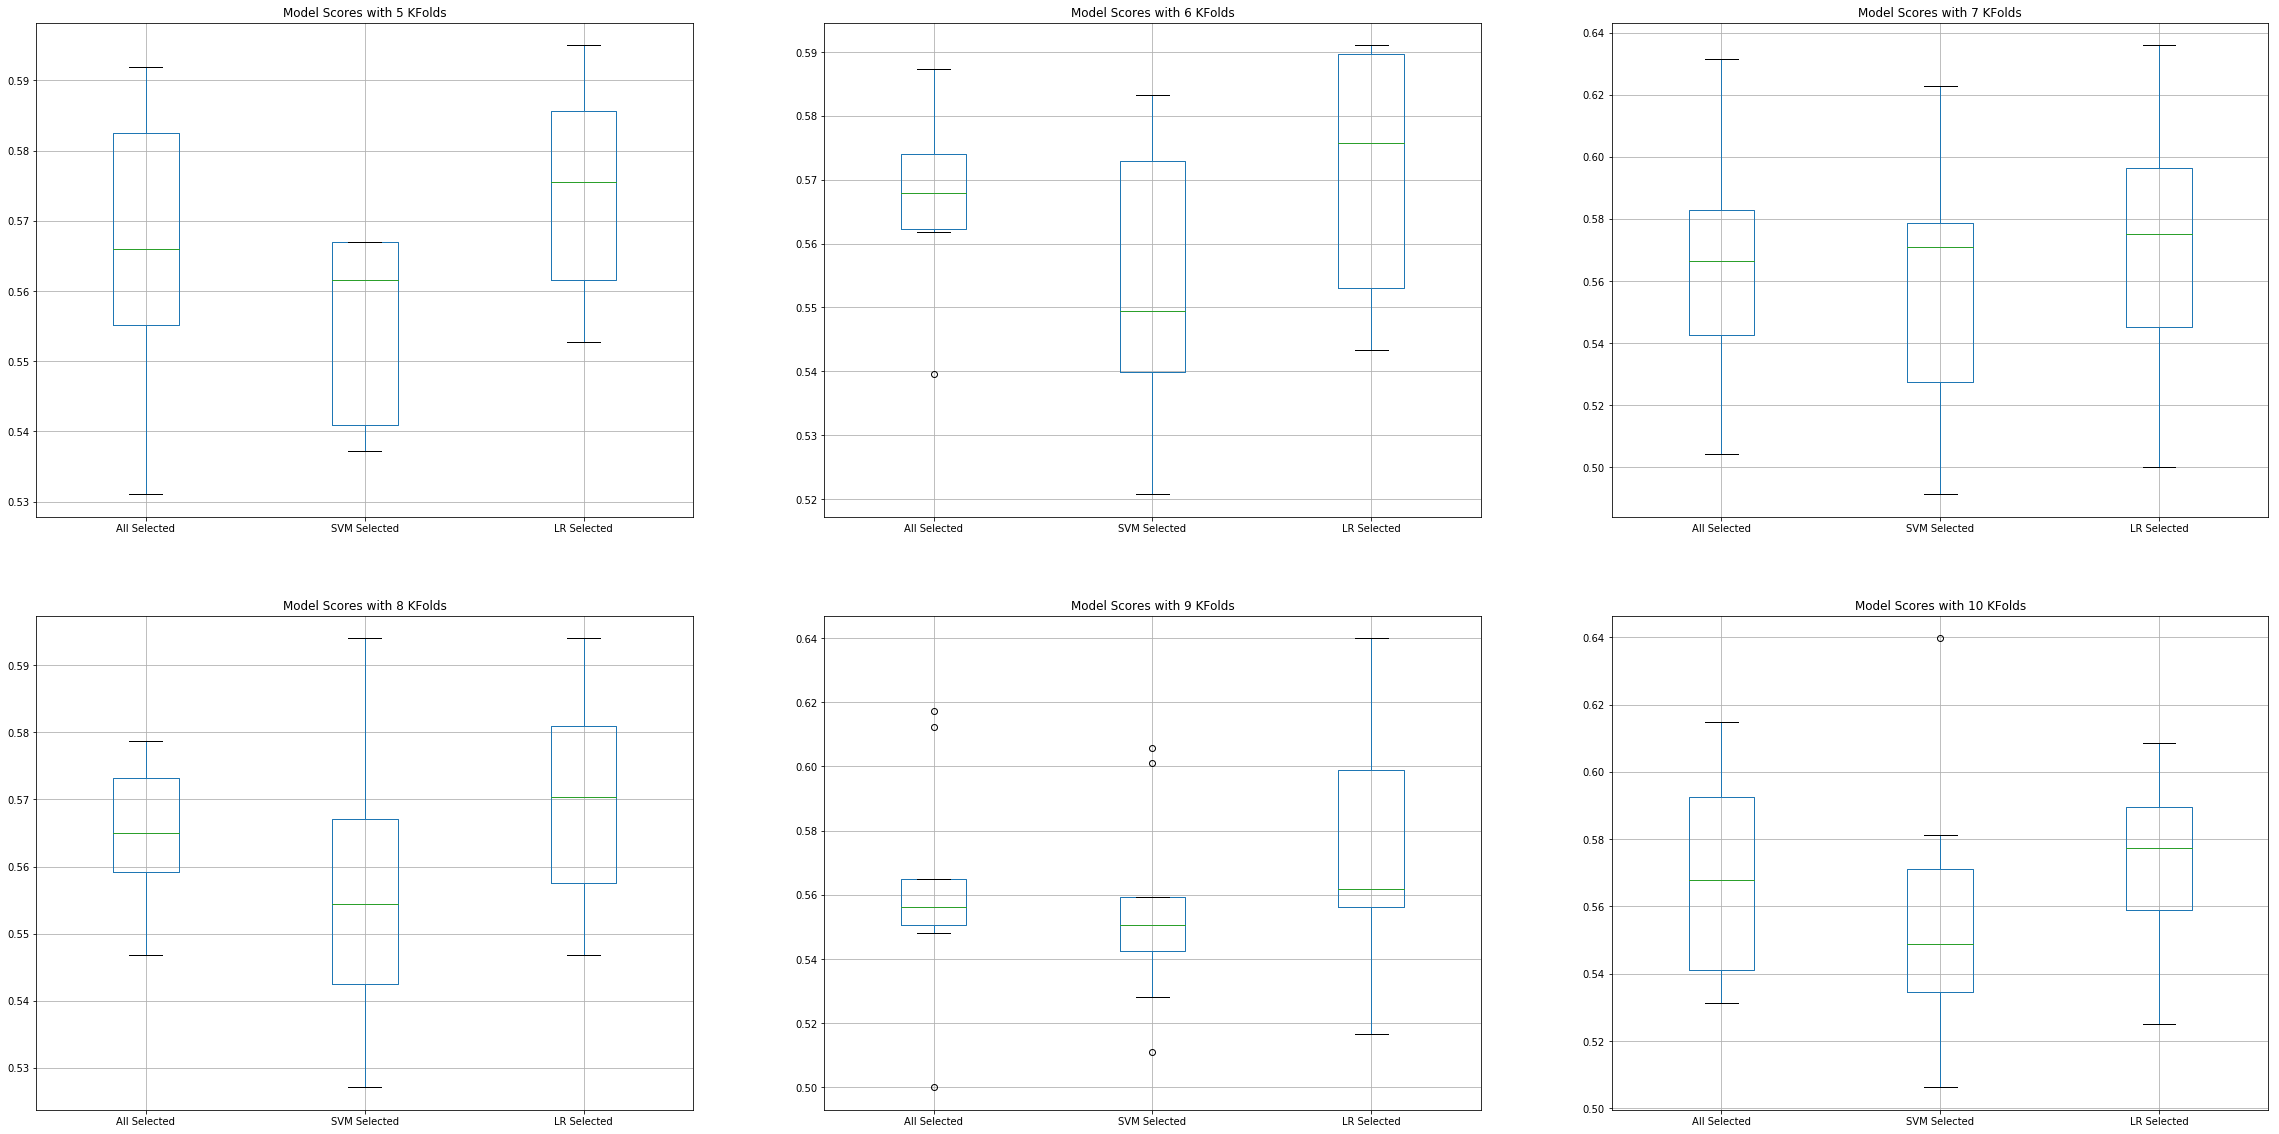

In [41]:
from sklearn.model_selection import StratifiedKFold
f = plt.figure(figsize=(40,20))
clf = svm.SVC(gamma='auto')

columns=['All Selected','SVM Selected', 'LR Selected']
all_scores = pd.DataFrame(columns=['kfold',*columns])


for i in range(5,11):
    
    k_fold_scores = pd.DataFrame(columns=columns)
    k_fold = StratifiedKFold(n_splits=i, shuffle=True)
    k_fold.get_n_splits(predictors, target)
    
    for train_ind, test_ind in k_fold.split(predictors, target):
        X_train, X_test = predictors[train_ind], predictors[test_ind]
        y_train, y_test = target[train_ind], target[test_ind]
        scores = []
        
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        for selector in [selectorSVM,selectorLR]:
            X_train_selected = selector.transform(X_train)
            X_test_selected = selector.transform(X_test)
            clf.fit(X_train_selected, y_train)
            scores.append(clf.score(X_test_selected, y_test))
        
        k_fold_scores = k_fold_scores.append(pd.DataFrame([scores], columns=columns))
    
    ax = f.add_subplot(2,3,i-4)
    k_fold_scores.boxplot()
    ax.set_title("Model Scores with {} KFolds".format(i))
    k_fold_scores['kfold'] = i
    all_scores = all_scores.append(k_fold_scores,sort=False, ignore_index=True)
f.show()

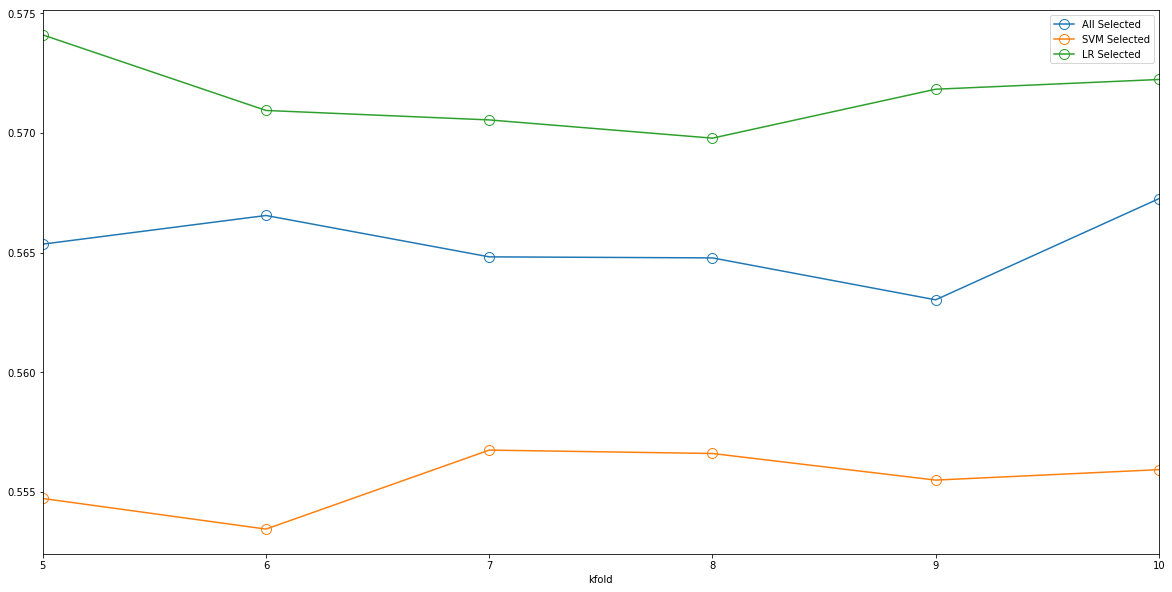

In [67]:
all_scores.groupby('kfold').mean().plot(figsize=(20,10),marker='o',fillstyle='none', markersize=10)
plt.show()

# Task 3
  * Build two pipelines for training classifiers for the dataset winequality_red.csv and summarise the results from training classifiers with the pipelines in a markdown cell (max 150 words).
  * The two pipelines should include feature-selection methods, and the feature-selection method in pipeline 1 should be different from the feature-selection method in pipeline 2.


#### Rubric

| Beginning [0-8]       | Developing [9-12]           | Accomplished [13-16]  |Exemplary [17-20] |
| ------------- |:-------------:| -----:|-------------|
| Pipelines attempted but with run-time errors.    | One pipeline implemented without errors. Results not summarised. | Two pipelines implemented without errors but both using the same feature-selection method. Results summarised. | Two pipelines implemented without errors. The feature-selection method in pipeline 1 different from the feature-selection method in pipeline 2. Results summarised. |

In [78]:
clf = ExtraTreesClassifier(n_estimators=3)
clf = clf.fit(predictors_train, target_train)
feature = pd.DataFrame({'name':num_cols,'score':clf.feature_importances_,}).sort_values(by='score', ascending=False)
feature['rank'] = np.arange(len(feature.index))+1
feature

,name,score,rank
10,alcohol,0.172037,1
1,volatile acidity,0.114748,2
6,total sulfur dioxide,0.101343,3
9,sulphates,0.090123,4
0,fixed acidity,0.088669,5
7,density,0.081730,6
4,chlorides,0.074786,7
5,free sulfur dioxide,0.072881,8
2,citric acid,0.071298,9
8,pH,0.069320,10


In [174]:
X_train, X_val, y_train, y_val = train_test_split(predictors, target, test_size=0.20, shuffle=True, stratify=target)

pipeline1 = Pipeline([
    ('min_max',    preprocessing.MinMaxScaler()),
    ('feat_sel', SelectKBest(score_func=chi2, k=3)),
    ('clf', LogisticRegression()),
])

pipeline2 = Pipeline([
    ('min_max',    preprocessing.MinMaxScaler()),
    ('feat_sel', RFE(ExtraTreesClassifier(), 3)),
    ('clf', LogisticRegression()),
])

pipeline3 = Pipeline([
    ('min_max',    preprocessing.MinMaxScaler()),
    ('feat_sel', RFE(LogisticRegression(solver='lbfgs',multi_class='multinomial'), 3)),
    ('clf', LogisticRegression()),
])

clfs = {'SelectKBest':pipeline1,'RFE Tree':pipeline2,'RFE LR':pipeline3}

columns=['KFold', 'Pipeline', 'Avg CV Score', 'Test Score','Valadation Score','Feature 1','Feature 2','Feature 3']
pipeline_reults = pd.DataFrame(columns=columns)

for i in range(5,11):
    k_fold = StratifiedKFold(n_splits=i, shuffle=True)
    for clf_name in clfs:
        clf = clfs[clf_name]
        results = cross_val_score(clf, X_train, y_train, cv=k_fold,n_jobs=-1)
        clf.fit(X_train, y_train)
        result_test = clf.score(X_train, y_train)
        result_val = clf.score(X_val, y_val)
        feat = list(np.where(clf.named_steps['feat_sel'].get_support()))
        pipeline_reults = pipeline_reults.append(pd.DataFrame([[i,clf_name,results.mean(),result_test,result_val,feat[0][0],feat[0][1],feat[0][2]]], columns=columns))

pipeline_reults['Delta Score'] = np.abs(pipeline_reults['Valadation Score'] - pipeline_reults['Avg CV Score'])

In [176]:
pipeline_reults.sort_values(by=['Pipeline','Delta Score'])

,KFold,Pipeline,Avg CV Score,Test Score,Valadation Score,Feature 1,Feature 2,Feature 3,Delta Score
0,9,RFE LR,0.559121,0.557467,0.565625,1,9,10,0.006504
0,7,RFE LR,0.557493,0.557467,0.565625,1,9,10,0.008132
0,10,RFE LR,0.557332,0.557467,0.565625,1,9,10,0.008293
0,5,RFE LR,0.554406,0.557467,0.565625,1,9,10,0.011219
0,8,RFE LR,0.554244,0.557467,0.565625,1,9,10,0.011381
0,6,RFE LR,0.551211,0.557467,0.565625,1,9,10,0.014414
0,8,RFE Tree,0.566026,0.566849,0.565625,6,9,10,0.000401
0,6,RFE Tree,0.564576,0.566849,0.565625,6,9,10,0.001049
0,10,RFE Tree,0.564455,0.566849,0.565625,6,9,10,0.001170
0,9,RFE Tree,0.563658,0.566849,0.565625,6,9,10,0.001967


In [177]:
for i in [1,2,6,9,10]:
    print ("{} = {} ".format(i,num_cols[i]))

1 = volatile acidity 
2 = citric acid 
6 = total sulfur dioxide 
9 = sulphates 
10 = alcohol 
